# Installing and importing

In [ ]:
%pip install paddlepaddle-gpu -q
%pip install paddleocr -q
%pip install --quiet vietocr
%pip install paddlepaddle -q

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

from paddleocr import PaddleOCR, draw_ocr

# Ultilities

In [6]:
!git clone https://github.com/PaddlePaddle/PaddleOCR
!git clone https://github.com/pbcquoc/vietocr

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 47581, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 47581 (delta 531), reused 646 (delta 432), pack-reused 46759
Receiving objects: 100% (47581/47581), 345.25 MiB | 2.39 MiB/s, done.
Resolving deltas: 100% (33383/33383), done.
Cloning into 'vietocr'...
remote: Enumerating objects: 3178, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 3178 (delta 662), reused 642 (delta 638), pack-reused 2477
Receiving objects: 100% (3178/3178), 2.08 MiB | 2.54 MiB/s, done.
Resolving deltas: 100% (2383/2383), done.


In [7]:
FONT = 'PaddleOCR/doc/fonts/latin.ttf'
def predict(recognitor, detector, img_path, save_path, padding=4, dpi=200):
    # Load image
    img = cv2.imread(img_path)

    # Text detection
    result = detector.ocr(img_path, cls=False, det=True, rec=False)
    result = result[:][:][0]

    # Filter Boxes
    boxes = []
    for line in result:
        boxes.append([[int(line[0][0]), int(line[0][1])], [int(line[2][0]), int(line[2][1])]])
    boxes = boxes[::-1]

    # Add padding to boxes
    padding = 4
    for box in boxes:
        box[0][0] = box[0][0] - padding
        box[0][1] = box[0][1] - padding
        box[1][0] = box[1][0] + padding
        box[1][1] = box[1][1] + padding

    # Text recognizion
    texts = []
    for box in boxes:
        cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        try:
            cropped_image = Image.fromarray(cropped_image)
        except:
            continue

        rec_result = recognitor.predict(cropped_image)

        text = rec_result#[0]

        texts.append(text)
        #print(text)

    # Convert boxes to draw
    def get_rectangle_points(x1, y1, x2, y2):
        x_tl = x1
        y_tl = y2
        x_br = x2
        y_br = y1
        return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    _boxes = [get_rectangle_points(boxe[0][0], boxe[0][1], boxe[1][0], boxe[1][1]) for boxe in boxes]

    # Draw boxes and texts
    img = draw_ocr(img, _boxes, texts, scores=None, font_path=FONT)


    # Save image
    img_name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(save_path, img_name), img)

    # Display image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    height, width, depth = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray')

    plt.show()

    return boxes, texts

def display_image_in_actual_size(img_path, dpi=200):
  im_data = cv2.imread(img_path)

  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image.
  ax.imshow(im_data, cmap='gray')

  plt.show()

# Configuration

In [8]:
# Config of PaddleOCR
detector = PaddleOCR(use_angle_cls=False, use_gpu=False)

[2023/11/15 10:06:46] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/hungtrieu07/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/hungtrieu07/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2

In [12]:
# Configure of VietOCR
config = Cfg.load_config_from_name('vgg_transformer')

config['cnn']['pretrained'] = True
config['predictor']['beamsearch'] = True

if torch.cuda.is_available():
    print("Your machine support CUDA")
    config['device'] = "cuda:0"
else:
    print("Your machine don't have CUDA GPU. Using CPU instead...")
    config['device'] = 'cpu'

recognitor = Predictor(config)

Your machine don't have CUDA GPU. Using CPU instead...
Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


# Only VietOCR

In [ ]:
import glob, os
from tqdm import tqdm

img_files = glob.glob("cropped_text_images/*.png")

progress_bar = tqdm(total=len(img_files), desc="Processing images", unit="file")

for img_file in img_files:

    img = cv2.imread(img_file)
    img = Image.fromarray(img)
    rec_result = recognitor.predict(img)

    print(img_file + "\t" + rec_result)
    progress_bar.update(1)
progress_bar.close()

# Paddle + VietOCR

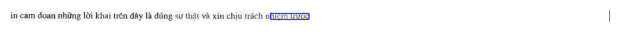

[[956, 12], [1097, 34]]: phiêm trước


In [13]:
input_path = '/home/hungtrieu07/Downloads/vietnamese-ocr/cropped_text_images/cropped_text_0_185_1101_229.png'
output_path = '/home/hungtrieu07/Downloads/vietnamese-ocr/test_output'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=200)
for i, (box, text) in enumerate(zip(boxes, texts)):
  print("{}: {}".format(box, text))

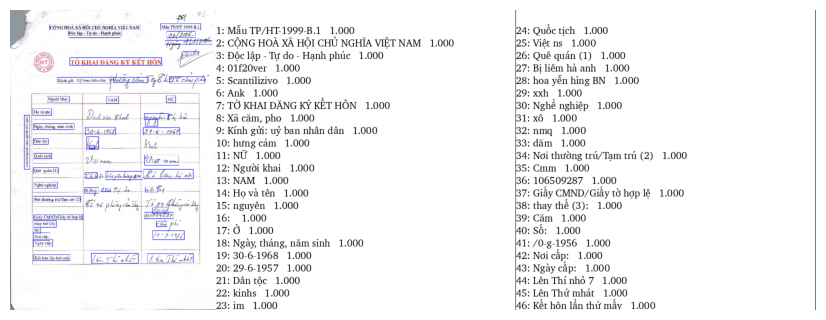

[[1158, 104], [1465, 153]]: Mẫu TP/HT-1999-B.1
[[305, 111], [999, 153]]: CỘNG HOÀ XÃ HỘI CHỦ NGHĨA VIỆT NAM
[[446, 157], [857, 199]]: Độc lập - Tự do - Hạnh phúc
[[1206, 163], [1422, 214]]: 01f20ver
[[1191, 233], [1552, 264]]: Scantilizivo
[[1325, 320], [1449, 353]]: Ank
[[458, 366], [1166, 424]]: TỜ KHAI ĐĂNG KÝ KẾT HÔN
[[1224, 512], [1496, 561]]: Xã căm, pho
[[364, 517], [768, 561]]: Kính gửi: uỷ ban nhân dân
[[797, 517], [1058, 559]]: hưng cám
[[1200, 657], [1274, 713]]: NỮ
[[284, 661], [454, 710]]: Người khai
[[738, 664], [836, 715]]: NAM
[[173, 760], [320, 809]]: Họ và tên
[[1031, 796], [1220, 845]]: nguyên
[[109, 808], [150, 1224]]: 
[[1038, 839], [1135, 893]]: Ở
[[177, 873], [492, 919]]: Ngày, tháng, năm sinh
[[578, 902], [813, 960]]: 30-6-1968
[[1024, 904], [1305, 960]]: 29-6-1957
[[178, 988], [294, 1032]]: Dân tộc
[[589, 973], [681, 1069]]: kinhs
[[612, 1038], [651, 1066]]: im
[[180, 1101], [320, 1143]]: Quốc tịch
[[1036, 1114], [1295, 1194]]: Việt ns
[[178, 1211], [374, 1260]

In [18]:
input_path = '/content/drive/MyDrive/doan/2.jpg'
output_path = '/content/'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=200)
for i, (box, text) in enumerate(zip(boxes, texts)):
  print("{}: {}".format(box, text))

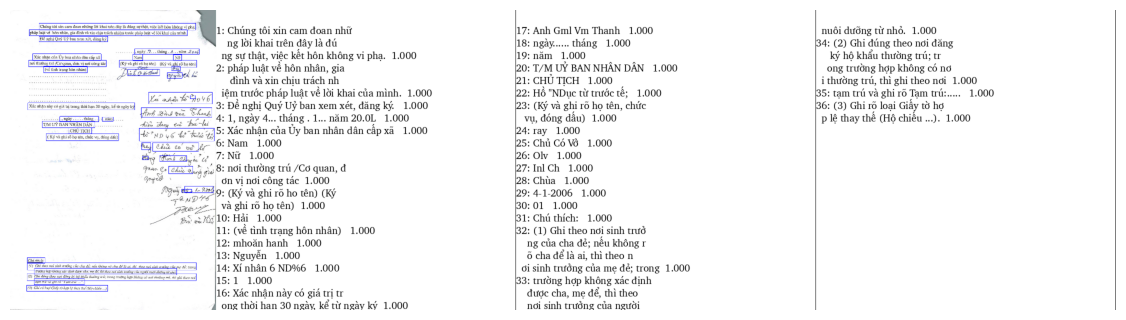

[[222, 101], [1423, 153]]: Chúng tôi xin cam đoan những lời khai trên đây là đúng sự thật, việc kết hôn không vi phạ.
[[147, 152], [1359, 198]]: pháp luật về hôn nhân, gia đình và xin chịu trách nhiệm trước pháp luật về lời khai của mình.
[[222, 200], [750, 244]]: Đề nghị Quý Uỷ ban xem xét, đăng ký.
[[956, 298], [1451, 339]]: 1, ngày 4... tháng . 1... năm 20.0L
[[173, 336], [698, 387]]: Xác nhận của Ủy ban nhân dân cấp xã
[[942, 338], [1018, 388]]: Nam
[[1252, 343], [1317, 387]]: Nữ
[[142, 384], [738, 435]]: nơi thường trú /Cơ quan, đơn vị nơi công tác
[[836, 386], [1432, 440]]: (Ký và ghi rõ ho tên) (Ký và ghi rõ họ tên)
[[1238, 430], [1305, 466]]: Hải
[[257, 430], [592, 481]]: (về tình trạng hôn nhân)
[[901, 454], [1146, 504]]: mhoăn hanh
[[1205, 480], [1319, 522]]: Nguyễn
[[1062, 631], [1550, 720]]: Xí nhân 6 ND%6
[[1382, 655], [1420, 680]]: 1
[[137, 712], [957, 766]]: Xác nhận này có giá trị trong thời hạn 30 ngày, kể từ ngày ký
[[1005, 749], [1548, 823]]: Anh Gml Vm Thanh
[[382, 

In [19]:
input_path = '/content/drive/MyDrive/doan/3.jpg'
output_path = '/content/'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=200)
for i, (box, text) in enumerate(zip(boxes, texts)):
  print("{}: {}".format(box, text))